In [4]:
import numpy as np
import igraph as ig
from ripser import ripser
from persim import plot_diagrams
from numba import jit
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/CarolineHerr/Documents/GitHub/Preferential-Attachment-Clique-Complex')
from simulator_pa import pa_generator
import betti

## Graph Generation and Parameter Selection

We'll first generate a scale-free graph using preferential attachment using the function pa_generator, which can be found in simulator_pa.py. (cite section from paper). The function will output an iGraph object simulated using the preferential attachment model.

The necessary parameters are:

num_nodes (int): Number of nodes in the graph (referred as $t$, i.e. how long the model is simulated for).

num_edges_per_new_node (int): Number of edges attached to the new node each time (referred as $m$).

$\delta$ (float): Parameter to control the rich-gets-richer effect. For smaller (more negative) delta, the effect is stronger.
        The power of of the tail of the degree distribution should be $\tau = 3 + \delta / m$.
        We choose -m < $\delta$ < 0 to ensure 2 < $\tau$ < 3.
        
seed (int): Seed for the random number geneator.

Because we're interested in the homology of the complex and scale-free network, we tend to select large m and smaller $\delta$ for more interesting results. 

In this tutorial, we'll work with $m = 7, \delta = -5$.

In order to make the visualize more interpretable, we'll use smaller num_nodes.


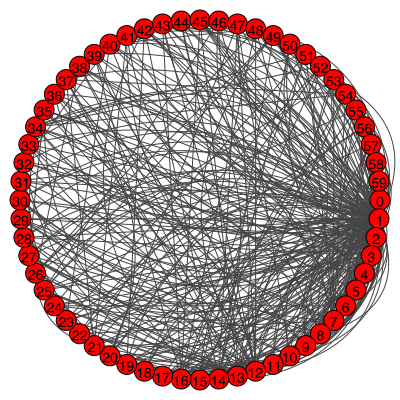

In [5]:
m = 7
delta = -5
T0 = 60
seed = 100
graph = pa_generator(T0, m, delta, seed)
layout = graph.layout_circle()
labels = [x for x in range(T0)]
ig.plot(graph, layout=layout, vertex_label = labels, bbox=(0, 0, 400, 400))

We can observe from the plot that the graph is likely scale-free, since there are a few nodes (typically nodes appearing early) with very high degrees, while the rest have lower degrees. We'll now generate a graph with larger t, with other parameters staying the same, to produce more interesting results about homology.

In [6]:
T = 20000
graph = pa_generator(T, m, delta, seed)

## Betti Numbers Calculation

We'll now calculate the betti numbers using Ripser, which helps us obtain the persistence diagram of the complex. In this example, we'll focus on betti numbers at the 2nd dimension.

We'll first demonstrate Ripser in a simple example, with four nodes and four edges constructing a square.

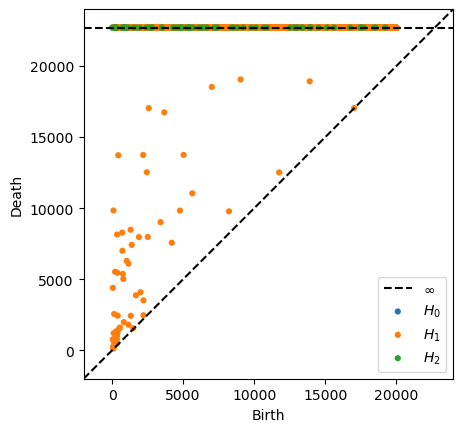

In [113]:
mat = betti.get_age_matrix(graph) # obtain the age matrix of the complex as an input for ripser
dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms'] # get the persistence diagrams
plot_diagrams(dgms)

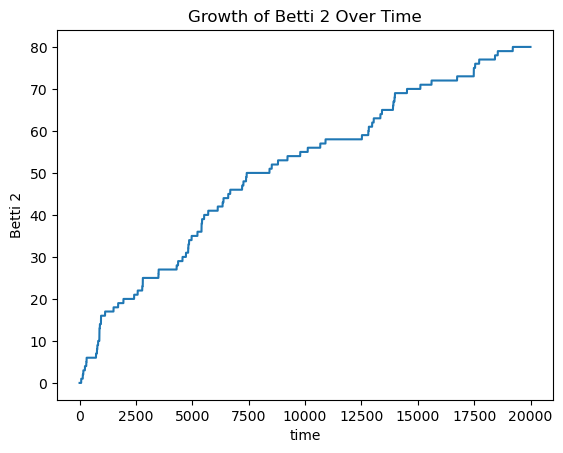

In [114]:
betti2_actual = betti.translate_PD_to_betti(dgms[2], T) # read the betti numbers from persistence diagrams
plt.plot(betti2_actual)
plt.xlabel('Time')
plt.ylabel('Betti 2')
plt.title('Growth of Betti 2 Over Time')
plt.show()

The above plot shows the growth of 2nd dimensional betti numbers over time. We'll now investigate the upper bounds and lower bounds.

The upper bound is found by $$\beta_q \leq \sum_{t \leq T} \text{rk } H_{q-1}(L^{(t)})$$ 
i.e., the cumulative sum of Betti q-1 of each node's link, where q represents the dimension (2 in our case).

In [115]:
def betti2_upper_bound(graph):
    """
    Return the upper bound for Betti 2 by finding the cumulative sum of Betti 1 of each node's link
    
    OUTPUT
    betti 2 upper bound at each time step as a list
    
    INPUT
    graph: igraph object
    
    """

    edge_list = np.array([e.tuple for e in graph.es])
    start = 0
    num_edges_per_new_node = int(len(edge_list)/(edge_list[-1][1]))
    end = num_edges_per_new_node
    new_betti1_in_batch = [0]

    while start < len(edge_list) and end <= len(edge_list):
        # find parents of each node
        parents_list = edge_list[start:end, 0]
        parents_list = np.unique(parents_list)

        # generate subgraph for the parents
        subgraph = graph.induced_subgraph(parents_list)

        # count the betti numbers
        mat = betti.get_age_matrix(subgraph)
        dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms']

        betti1 = 0
        for k, j in dgms[1]:
            betti1 += 1
            if j < float('inf'):
                betti1 -= 1

        new_betti1_in_batch.append(betti1)
        start += num_edges_per_new_node
        end += num_edges_per_new_node
    return np.cumsum(new_betti1_in_batch)

betti2_upper = betti2_upper_bound(graph)

The lower bound consists of three terms: $$\beta_q \geq \sum_{t \leq T} (l^{(t)} - b^{(t)}_{MC} - b^{(t)}_{KL})$$ where $$l^{(t)} = \mathbf{1}[(S^q)^{(t)}] $$

$$b^{(t)}_{MC} = \mathbf{1}[(S^q)^{(t)} \text{and rk ker }f_{q-1} = 0] $$

$$b^{(t)}_{KL} = \text{rk } H_q (L^{(t)})$$

Please refer to $\textit{Proposition 14}$ in paper for notations and details.

In [116]:
# helper functions for lower bound calculation

@jit(nopython=True)
def first_term_lower_bound(square, largest_square_node, t, numba_flag=True, graph=None, edge_list=None, m=None, par_col=None):
    first_term = List()
    for idx in range(largest_square_node+1):
        first_term.append(int(0))

    found_one_flag = 0
    for i in range(largest_square_node+1, t):
        if True:
            fill = betti.check_node_square_connection(
                edge_list, i, square, m=m)
        if fill:
            if found_one_flag == 0:  # The first filling does not count
                first_term.append(0)
                found_one_flag = 1
            else:
                first_term.append(1)
        else:
            first_term.append(0)

    return first_term

def second_term_lower_bound(graph, square, first_term):
    t = graph.vcount()
    edge_list = np.array([e.tuple for e in graph.es])
    # m = int(len(edge_list)/(edge_list[-1][1]))
    largest_square_node = max(square)
    link_betti2 = [0 for idx in range(largest_square_node+1)]
    for i in range(largest_square_node + 1, t):
        if first_term[i] >= 1:
            mat = betti.get_link_matrix(graph, square, i)
            dgms = ripser(mat, distance_matrix=True, maxdim=1)['dgms']
            link_betti2.append(int(
                any([pt[1] == 2 for pt in dgms[1]])
            ))
        else:
            link_betti2.append(0)
    return np.cumsum(link_betti2)


In [117]:
def betti2_lower_bound(graph, time = 20):

    """
    Return the lower bound of Betti 2. 
    The lower bound is found by the above inequality.
    
    OUTPUT
    betti 2 lower bound at each time step as a list
    
    INPUT
    graph: igraph object
    time: the time constraint for the appearance of the square
    """
    t = graph.vcount()
    boo, square = betti.check_square_appearance(graph, time)

    edge_list = np.array([e.tuple for e in graph.es])
    num_edges_per_new_node = int(len(edge_list)/(edge_list[-1][1]))
    if not boo:
        first_term_sum = np.array([0 for idx in range(t)])
    else:
        largest_square_node = max(square)
        first_term = first_term_lower_bound(np.array(
            square), largest_square_node, t, edge_list=edge_list, m=num_edges_per_new_node, par_col=0)
        first_term_sum = np.cumsum(first_term)

    if not boo:
        second_term = np.array([0 for idx in range(t)])
    else:
        second_term = second_term_lower_bound(
            graph, square, first_term)

    start = 0
    end = num_edges_per_new_node
    new_betti2_in_batch = [0]

    while start < len(edge_list) and end <= len(edge_list):
        parents_list = edge_list[start:end, 0]
        parents_list = np.unique(parents_list)

        # generate subgraph for the parents
        subgraph = graph.induced_subgraph(parents_list)

        # count the betti numbers
        mat = betti.get_age_matrix(subgraph)
        dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms']

        betti2 = 0
        for k, j in dgms[2]:
            betti2 += 1
            if j < float('inf'):
                betti2 -= 1

        new_betti2_in_batch.append(betti2)
        start += num_edges_per_new_node
        end += num_edges_per_new_node
    third_term = np.cumsum(new_betti2_in_batch)
    lower_bound = first_term_sum - second_term - third_term
    return lower_bound

betti2_lower = betti2_lower_bound(graph)

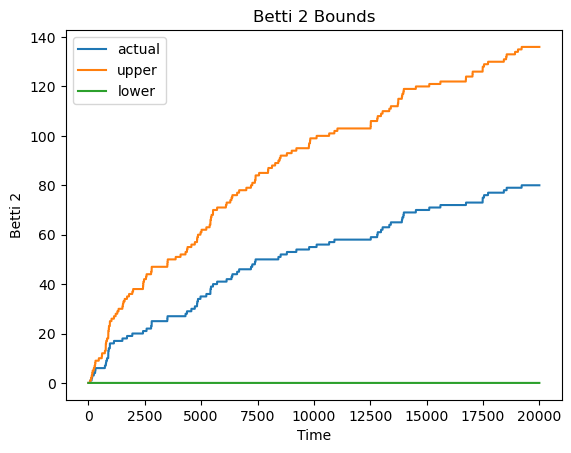

In [120]:
plt.plot(betti2_actual, label = 'actual')
plt.plot(betti2_upper, label = 'upper')
plt.plot(betti2_lower, label = 'lower')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Betti 2')
plt.title('Betti 2 Bounds')
plt.show()